<center><img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F450%2F1*CXZ804tKLPy2hiikJbYH3w.png&f=1&nofb=1" width=30% ></center>

# <center> Assignment 4: Image Alignment and Stitching </center>
<center> Computer Vision 1, University of Amsterdam </center>
    <center> Due 23:59, October 8, 2022 (Amsterdam time) </center>
    
***

## General guidelines
Your code and discussion must be completed in this **jupyter notebook** before the deadline by submitting it to the Canvas Lab 4 Assignment. Submit your assignment in a **zip file**, with all the relevant files and images need to run your notebook. Name your zip file as follows: **StudentID1_StudentID2_StudentID3.zip**. For full credit, make sure your answers follow these guidelines:
- Make sure you use the provided python environment. You can create the environment using conda and the provided YAML file using the following command: `conda env create --file=cv1lab4.yaml`, then activate it as `conda activate cv1lab4`. Using different packages versions may result in the impossibility to run the submitted code and therefore in the subtraction of points. Below you will find a code cell to check the versions of your packages. 
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make the report self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.
- Make sure all the code in your notebook runs without errors or bugs before submitting. Code that does not run can result in a lower grade.

**Late submissions are not allowed**. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs' system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

**Plagiarism note**: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

****

In [1972]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

In [1973]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.


# Image Alignment (60pts)

In this practice, you will write a function that takes two images as
input and computes the affine transformation between them. You will work
with supplied images. The overall scheme is as follows:

  1.  Detect interest points in each image.

  2.  Characterize the local appearance of the regions around interest
      points.

  3.  Get the set of supposed matches between region descriptors in each
      image.

The first three steps can be performed using David Lowe's SIFT. Check
out the Docs of SIFT related function for further information in the
following link:
<https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html> and
<https://docs.opencv.org/3.4.9/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html>.

4.  Perform RANSAC to discover the best transformation between images. RANSAC should be performed as follows:

  -   Repeat $N$ times:

  -   Pick $P$ matches at random from the total set of matches $T$.

  -   Construct a matrix $A$ and vector $b$ using the $P$ pairs of points and find affine transformation parameters $(m1, m2, m3, m4, t1, t2)$ (see [Question 2.1](#q2.1)) by solving the equation $Ax = b$. Such equation can be solved using the pseudo-inverse: $x = (A^T A)^{-1} A^T b$, or packages of Numpy in Python.

  - Using the transformation parameters, transform the locations of all $T$ points in image1. If the transformation is correct, they should lie close to their counterparts in image2. Plot the two images side by side with a line connecting the original $T$ points in image1 and transformed $T$ points over image2.
      
  - Count the number of inliers, where inliers are defined as the number of transformed points from image1 that lie within a radius of $10$ pixels of their pair in image2.

  - If this count exceeds the best total so far, save the transformation parameters and the set of inliers.

  - End repeat.

5. Finally, transform image1 using this final set of transformation parameters. If you display this image, you should find that the pose of the object in the scene should correspond to its pose in image2. To transform the image, implement your own function based on **nearest-neighbor interpolation**. Then use the OpenCV built-in function `cv2.warpAffine` and compare your results.<br>
Note, nearest neighbors does not mean you have to classify points. The problem is that if you have a transformation, then the transformed points may not be at perfect pixels (e.g., 0.3px). Instead of linear interpolation, which requires more work to implement, we can just use nearest neighbors which means simply **rounding the coordinates**.

## Question 1

### Question 1.1

Create a function that takes image pairs `street1.png` and `street2.png` as input,and return the keypoint matchings between the two images. <br><br>
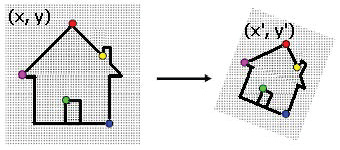

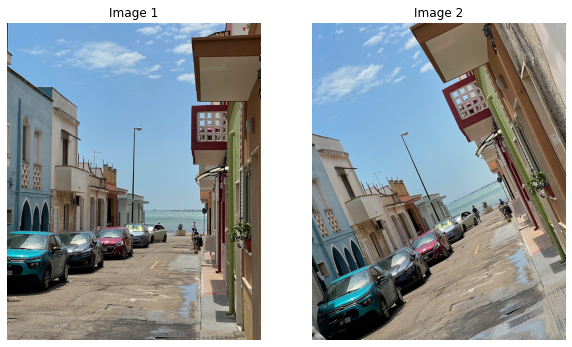

In [1974]:
img1_path = "street1.png" 
img2_path = "street2.png"

# Open images
img1 = cv2.imread("street1.png")
img2 = cv2.imread("street2.png")

# Note: OpenCV uses BGR instead of RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Display images
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img1)
ax[0].axis('off')
ax[0].set_title('Image 1')
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title('Image 2')
plt.show()
plt.close()

**Note:** For some patent issue, the newest version of OpenCV does not contain SIFT-related function. Therefore, the provided environment uses an older version of the pacakge (`opencv-contrib-python==3.4.2.17`). If you can't run the cell below, make sure you are using the `cv1` python environment.

In [1975]:
def keypoint_matching(image1, image2):
  """
    Given two input images, find and return the matching keypoints.
    Arguments:
    image1: the first image (in RGB)
    image2: the second image (in RGB)
    Returns: 
    The keypoints of image1, the keypoints of image2 and the matching
    keypoints between the two images
  """

  print('\nFinding matching features...')
  
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(image1, None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(image2, None)

  img1 = cv2.drawKeypoints(image1, keypoints_1, image1)    
  img2 = cv2.drawKeypoints(image2, keypoints_2, image2)

  matches = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

  matches = matches.match(descriptors_1, descriptors_2)
  matches = sorted(matches, key=lambda x : x.distance)

  print("Number of keypoints in img1:        ", len(keypoints_1))
  print("Number of keypoints in img2:        ", len(keypoints_2))
  print("Number of keypoints after matching: ", len(matches), "\n")

  return keypoints_1, keypoints_2, matches

In [1976]:
# Find and match key points
image1 = cv2.imread("street1.png")
image2 = cv2.imread("street2.png")

image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

keypoints_1, keypoints_2, matches = keypoint_matching(image1_gray, image2_gray)


Finding matching features...
Number of keypoints in img1:         2008
Number of keypoints in img2:         2050
Number of keypoints after matching:  1234 



### Question 1.2
Take a random subset (with set size set to 10) of all matching points, and plot on the image. Connect matching pairs with lines. You can assign a random color to each line to make them easier to distinguish.

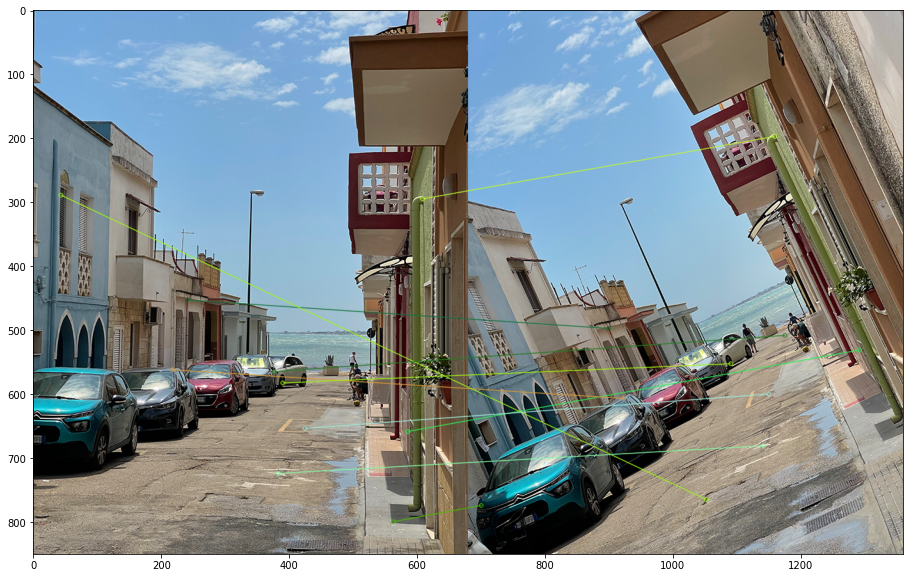

In [1977]:
# Extract 10 random matches to plot
random_matches = [matches[i] for i in random.sample(range(0, len(matches)), 10)]

# Now plot them. Hint: for generating the plot, you can use cv2.drawMatches()
image = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, random_matches, None, flags=2)

plt.figure(figsize=(100, 10))
plt.imshow(image)
plt.show()

### Question 1.3
Create a function that performs the RANSAC algorithm as explained above. The function should return the best transformation found. For visualization, show the transformations from image1 to image2 and from image2 to image1.

In [1978]:
# Self-designed functions 'get_grid' and 'affine_transform' for ranasc algorithm.

def get_grid(h, w):
  # Generates HOMOGENEOUS coordinates of an image in a grid-like fashion.
  """
  Arguments:
  w, h: the width and height of the image
  Returns: 
  HOMOGENEOUS coordinates
  """
  grid = np.empty(shape=(h, w, 3))

  for i in range(h):
    for j in range(w):
      grid[i][j][0] = j
      grid[i][j][1] = i
      grid[i][j][2] = 1

  return grid


def affine_transform(img, mat, warp='forward'):
  #Applies the affine transformation defined in mat to the image contained in img.
  #Works in homogeneous coordinates.
  """
  Arguments:
  img: the first/second image (img1 or img2)
  mat: transformation matrix
  warp: forward or inverse warping
  Returns:
  transformed image
  """
  output = np.ones(shape=img.shape, dtype=np.int)
  h, w, _ = img.shape

  img_coords = get_grid(h, w)

  if warp =='forward':
    for i in range(h):
      for j in range(w):
        coords = mat @ img_coords[i][j]
        
        x_prime = int(np.rint(coords[0]))
        y_prime = int(np.rint(coords[1]))

        if 0 <= y_prime < h and 0 <= x_prime < w:
          output[y_prime][x_prime] = img[i][j]

  if warp == 'inverse':
    for i in range(h):
      for j in range(w):
        mat_transform = np.append(mat, np.array([[0, 0, 1]]), axis=0)
        coords = np.linalg.inv(mat_transform) @ img_coords[i][j] 

        if coords[2]:
          coords[0] /= coords[2]
          coords[1] /= coords[2]

        x_prime = int(np.rint(coords[0]))
        y_prime = int(np.rint(coords[1]))

        if 0 <= y_prime < h and 0 <= x_prime < w:
          output[i][j] = img[y_prime][x_prime]

  return output

In [1979]:
def ransac(kp1, kp2, matches, N):
  """
    Arguments:
      kp1: the keypoints of image1, 
      kp2: the keypoints of image2
      matches: the matching keypoints between the two images
      N: number of iterations
    Returns: 
      the best transformation matrix
  """
  P = 3
  VALID_RADIUS_INLIER = 10

  best_inliers = 0
  best_matrix = None
  
  for iteration in range(N):
    matches_subset = random.sample(matches, P)

    A = np.empty(shape=(0, 6))
    b = np.empty(shape=(0))

    for match in matches_subset:
      (xs, ys) = kp1[match.queryIdx].pt # i.e. keypoint from first image
      (xd, yd) = kp2[match.trainIdx].pt

      A = np.append(A, [xs, ys, 0, 0, 1, 0])
      A = np.append(A, [0, 0, xs, ys, 0, 1])

      b = np.append(b, xd)
      b = np.append(b, yd)

    A = np.reshape(A, (A.shape[0] // 6, 6))
    mat = np.linalg.lstsq(A, b, rcond=None)[0]

    transform = np.array([
      [mat[0], mat[1], mat[4]],
      [mat[2], mat[3], mat[5]],
    ])

    inliers = 0

    for match in matches:
      source = np.array(kp1[match.queryIdx].pt) # i.e. keypoint from first image
      source = np.append(source, 1)
      
      destination = np.array(kp2[match.trainIdx].pt)
      
      transformed_source = transform @ source

      if np.linalg.norm(transformed_source - destination) <= 10:
        inliers += 1
        
    if inliers > best_inliers:
      best_matrix = np.copy(transform)
      best_inliers = inliers

  print("Total number of matches: ", len(matches))
  print("Inliers found:           ", best_inliers)
  print("Outliers removed:        ", len(matches) - best_inliers)

  return best_matrix

In [1980]:
def visualization(img, best_matrix):
  """
    Arguments:
      img: the first/second image (img1 or img2)
      best_matrix: the best transformation matrix
  """  
  # Visualize/export a comparison: "Forward warping", "Inverse warping", 
  # "OpenCV warping", "Original image". Refer to the output of the next
  # cell to see the expected output.

  _, axis = plt.subplots(1, 4, figsize=(30, 30))

  forward_warped_image = affine_transform(img, best_matrix)
  axis[0].imshow(forward_warped_image)
  axis[0].set_title("Forward warping")

  inverse_warped_image = affine_transform(img, best_matrix, warp="inverse")
  axis[1].imshow(inverse_warped_image)
  axis[1].set_title("Inverse warping")

  cv2_forward_warp = cv2.warpAffine(img, best_matrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
  axis[2].imshow(cv2_forward_warp)
  axis[2].set_title("OpenCV warping")

  cv2_inverse_warp = cv2.warpAffine(cv2_forward_warp, best_matrix, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP)
  # axis[3].imshow(cv2_inverse_warp)
  axis[3].imshow(img)
  axis[3].set_title("Original image")

  plt.show()

Total number of matches:  1234
Inliers found:            794
Outliers removed:         440


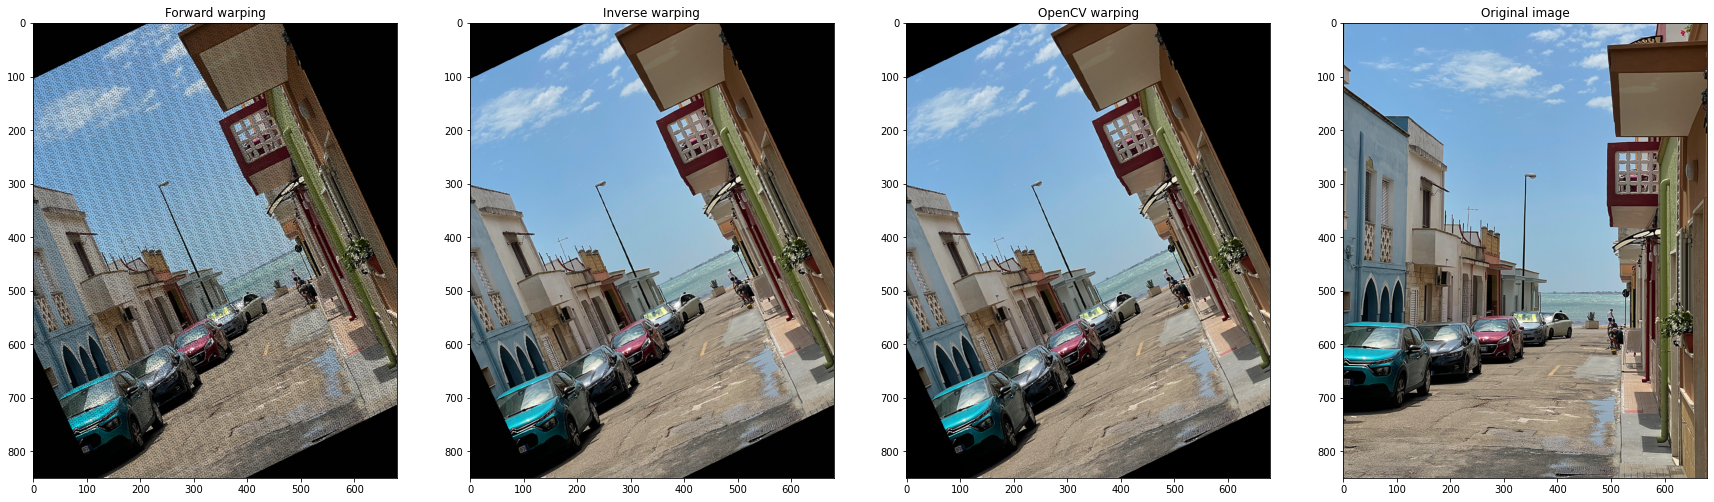

In [1981]:
N_iterations = 50 # experiment with this value!
best_matrix = ransac(keypoints_1, keypoints_2, matches, N_iterations)
visualization(img1, best_matrix)

## plot transformed keypoints 

# new_kp1 = [best_matrix @ np.array([*keypoint.pt, 1]) for keypoint in keypoints_1]
# new_kp1 = [cv2.KeyPoint(new_keypoint[0], new_keypoint[1], keypoint.size) for new_keypoint, keypoint in zip(new_kp1, keypoints_1)]

# matches_plot = cv2.drawMatches(img1, keypoints_1, img2, new_kp1, random_matches, None, flags=2)

# plt.figure(figsize=(100, 10))
# plt.imshow(matches_plot)

# matches_plot = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, random_matches, None, flags=2)

# plt.figure(figsize=(100, 10))
# plt.imshow(matches_plot)

# plt.show()

## Question 2
Based on the results, answer the following questions.

<a name="q2.1"></a>
### Question 2.1
How many matches do we need to solve an affine transformation which can be formulated as follows:

$$
\begin{bmatrix}
x'\\y'\end{bmatrix} =
\begin{bmatrix}
m_1 & m_2\\
m_3 & m_4
\end{bmatrix}
\begin{bmatrix}
x\\y\end{bmatrix}+
\begin{bmatrix}
t_1\\t_2\end{bmatrix}
$$

The equation above can be rewritten as:

$$
\begin{bmatrix}
x&y&0&0&1&0\\
0&0&x&y&0&1\end{bmatrix}
\begin{bmatrix}
m_1\\
m_2\\
m_3\\
m_4\\
t_1\\
t_2
\end{bmatrix} =
\begin{bmatrix}
x'\\y'\end{bmatrix}
$$
or, alternatively:
$$
Ax=b, \;
A = \begin{bmatrix}
x&y&0&0&1&0\\
0&0&x&y&0&1\end{bmatrix}, \;
x = \begin{bmatrix}
m_1\\
m_2\\
m_3\\
m_4\\
t_1\\
t_2
\end{bmatrix}, \;
b = \begin{bmatrix}
x'\\y'\end{bmatrix}
$$

### Answer

As the last equation shows we have 6 unknown variables, which means we should have 6 measure points. Since each point contains an x and y coordinate we need 3 matching points from each image.

### Question 2.2
How many iterations in average are needed to find good transformation parameters?

### Answer

Through experimentation on both image pairs, we found that on average 50 iterations are enough.

This question is hard to answer, since it depends on the keypoint matching algorithm.
When the matches between the two images are perfect only one iteration is needed to find a good transformation.
As the overal error between the two keypoints increases, the amount of iterations needed will also increase.

We want to point out that this question is hard to answer since; We first have to define what a "good transformation" is, what the allowed delta is (that tells whether the point was an inlier or not), and what the 𝑃 value is (Pick 𝑃 matches at random from the total set of matches 𝑇). What we are trying to say is that we have to assume many things to answer this question.

____

# Image Stitching (40pts)

In this practice, you will write a function that takes two images as input and stitch them together. The method described in the previous section will be used to stitch two images together by transforming one of them to the coordinate space of the other. You will work with supplied images *left.jpg* and *right.jpg*. The overall scheme can be summarized as follows:

1.   As in previous task you should first find the best transformation between input images.

2.   Then you should estimate the size of the stitched image.

3.   Finally, combine the *left.jpg* with the transformed *right.jpg* into one image.

## Question 3
### Question 3.1 
Create a function that takes an image pair as input, and return the stitched version.




In [1982]:
def stitchImages(img1, img2, N):
  """
  Given two input images, return the stitched image.
  Arguments:
    img1: the first image (in RGB)
    img2: the second image (in RGB)
  Returns: 
    The keypoint matchings between the two image
  """
  image1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  image2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  keypoints_1, keypoints_2, matches = keypoint_matching(image1_gray, image2_gray)
  
  transform = ransac(keypoints_1, keypoints_2, matches, N)

  offset = transform @ np.array([img2.shape[1] - 1, img2.shape[0] - 1, 1])
  offset = np.abs(offset)
  offset = np.array(offset, dtype=np.int)
  offset = np.append(offset, 0)

  transform[0][2] += offset[1] # add translation to transform
  transform[1][2] += offset[0]

  size = img1.shape + offset

  stitched_image = np.ones(size)

  inv_transform = np.linalg.inv(np.append(transform, [[0, 0, 1]], axis=0))

  for i in range(stitched_image.shape[0]):
    for j in range(stitched_image.shape[1]):
      coords = inv_transform @ np.array([j, i, 1])

      if coords[2]:
        coords[0] /= coords[2]
        coords[1] /= coords[2]
      
      x = coords[0]
      y = coords[1]

      x = int(np.rint(x))
      y = int(np.rint(y))

      if 0 <= y < img1.shape[0] and 0 <= x < img1.shape[1]:
        stitched_image[i][j] = img1[y][x]

  for i in range(img2.shape[0]):
    for j in range(img2.shape[1]):
      if i + offset[0] < stitched_image.shape[0] and j + offset[1] < stitched_image.shape[1]:
        stitched_image[i + offset[0]][j + offset[1]] = img2[i][j]

  return np.array(stitched_image, dtype=np.int)


Finding matching features...
Number of keypoints in img1:         709
Number of keypoints in img2:         881
Number of keypoints after matching:  415 

Total number of matches:  415
Inliers found:            87
Outliers removed:         328


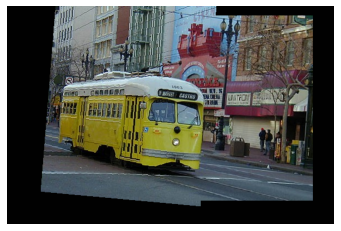

In [1983]:
img1_path = "left.jpg"
img2_path = "right.jpg"

# Load images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# Note: OpenCV uses BGR instead of RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Stitch images
N_iterations = 50 # Select based on your previous findings.
stitchedImage = stitchImages(img1, img2, N_iterations)

plt.imshow(stitchedImage)
plt.axis('off')
plt.show()
plt.close()

### Question 3.2
Visualize the stitched image alongside with the image pair.

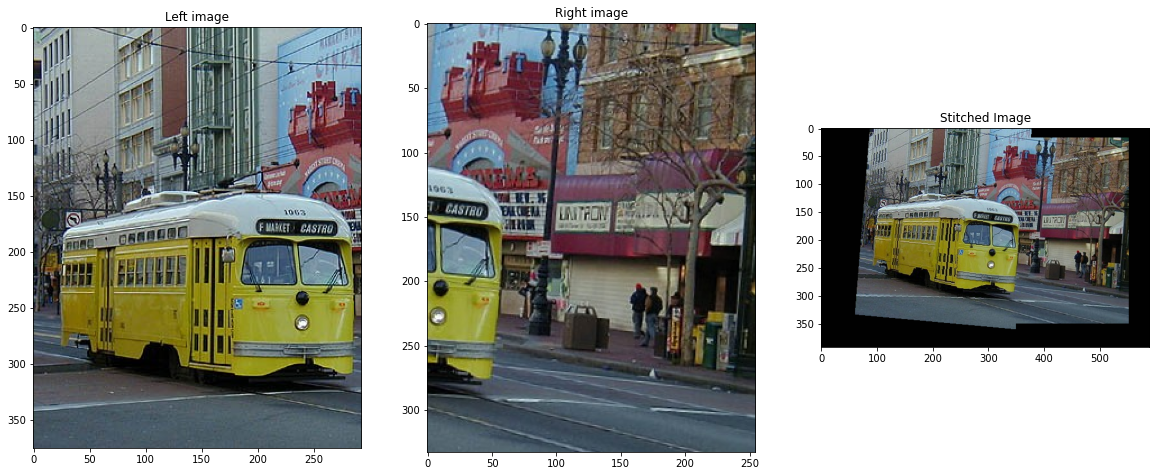

In [1984]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(img1)
axes[0].set_title("Left image")

axes[1].imshow(img2)
axes[1].set_title("Right image")

axes[2].imshow(stitchedImage)
axes[2].set_title("Stitched Image")

plt.show()